[Notion Notes](https://likeable-twilight-dff.notion.site/Housing-Prices-Notes-eccb6cdd9d33406f960603ea3a3213f4?pvs=4) Summary

Steps
1. EDA
2. Cleaning the data
3. Creating a pipeline
4. Choosing a model + parameter tuning + measuring performance
5. Specific feature engineering
6. Submitting!
7. Referencing other existing notebooks

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
df = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv', index_col = [0])
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# step 1: data exploration

In [3]:
numerical_data = df.select_dtypes(include=['int64','float64']).drop('SalePrice', axis=1)
# numerical_data.describe()
# note that MSSubClass is supposed to be a category but its written as a num here, change later

In [4]:
categorical_data = df.select_dtypes(include='object')
# categorical_data.describe()

In [5]:
# null values
pd.set_option('display.max_rows', None) 
has_null = df.isnull().sum().sort_values(ascending=False)[df.isnull().sum().gt(0)]
null_percent = (df.isnull().sum()/len(df)).sort_values(ascending=False)[df.isnull().sum().gt(0)]
has_null

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

In [6]:
null_percent
# since PoolQC, MiscFeature, and Alley have so many null values
# might be better to just split it into "having pool (1 0)" or "having alley" since so little exists

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
MasVnrType      0.597260
FireplaceQu     0.472603
LotFrontage     0.177397
GarageYrBlt     0.055479
GarageCond      0.055479
GarageType      0.055479
GarageFinish    0.055479
GarageQual      0.055479
BsmtExposure    0.026027
BsmtFinType2    0.026027
BsmtCond        0.025342
BsmtQual        0.025342
BsmtFinType1    0.025342
MasVnrArea      0.005479
Electrical      0.000685
dtype: float64

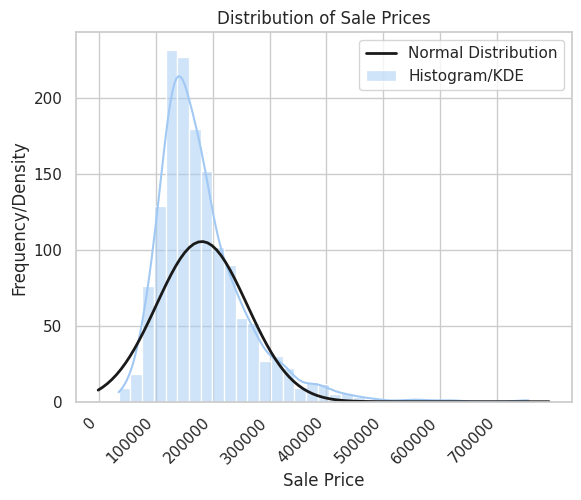

In [7]:
# note that the following was mostly generated through prompting ChatGPT
sale_price_data = df['SalePrice']

# Plot histogram and KDE
sns.set_theme(style="whitegrid", palette="pastel")
sns.histplot(sale_price_data, kde=True, bins=35, label='Histogram/KDE')

# Calculate mean and standard deviation for normal distribution
mean_sale_price = sale_price_data.mean()
std_sale_price = sale_price_data.std()

# Generate normal distribution PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean_sale_price, std_sale_price)

# Scale the PDF to match the histogram
p_scaled = p * len(sale_price_data) * np.diff(np.histogram(sale_price_data, bins=50)[1])[0]

# Plot normal distribution
plt.plot(x, p_scaled, 'k', linewidth=2, label="Normal Distribution")

# Add labels and title
plt.xlabel('Sale Price')
plt.xticks(np.arange(0, 800000, 100000), rotation=45, ha = "right") 
plt.ylabel('Frequency/Density')
plt.legend()
plt.title('Distribution of Sale Prices')

plt.show() # notice that the data is right-skewed

## inspecting specific variables

### categorical data

In [8]:
categorical_data.nunique().sort_values()[categorical_data.nunique().lt(12) & categorical_data.nunique().gt(3)]

BsmtQual         4
ExterQual        4
KitchenQual      4
BsmtCond         4
BsmtExposure     4
Fence            4
MiscFeature      4
LandContour      4
LotShape         4
FireplaceQu      5
Electrical       5
HeatingQC        5
GarageQual       5
GarageCond       5
MSZoning         5
LotConfig        5
BldgType         5
ExterCond        5
BsmtFinType1     6
RoofStyle        6
GarageType       6
Foundation       6
Heating          6
BsmtFinType2     6
SaleCondition    6
Functional       7
RoofMatl         8
HouseStyle       8
Condition2       8
SaleType         9
Condition1       9
dtype: int64

In [9]:
df.MSZoning.value_counts()

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

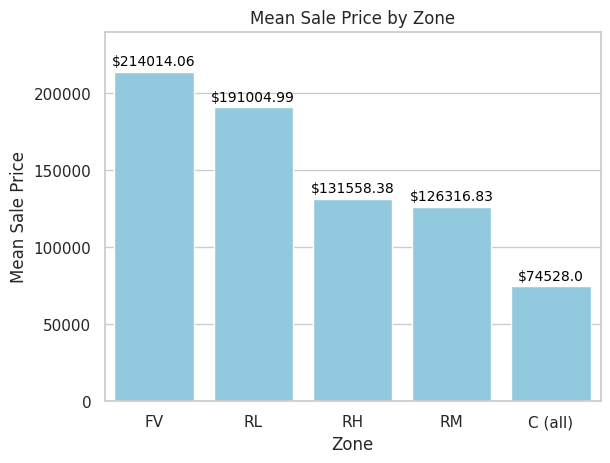

In [10]:
price_by_zone = df.groupby('MSZoning').SalePrice.mean().sort_values(ascending=False)
sns.barplot(x=price_by_zone.index, y=price_by_zone.values, color="skyblue")
plt.xlabel('Zone')
plt.ylabel('Mean Sale Price')
plt.ylim(0, 240000)
plt.title('Mean Sale Price by Zone')

# labelling generated with ChatGPT
for i, v in enumerate(price_by_zone.values):
    plt.text(i, v + 2000, "$" + str(round(v, 2)), color='black', ha='center', va='bottom', fontsize=10)
    
plt.show()

In [11]:
df.BldgType.value_counts()

BldgType
1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: count, dtype: int64

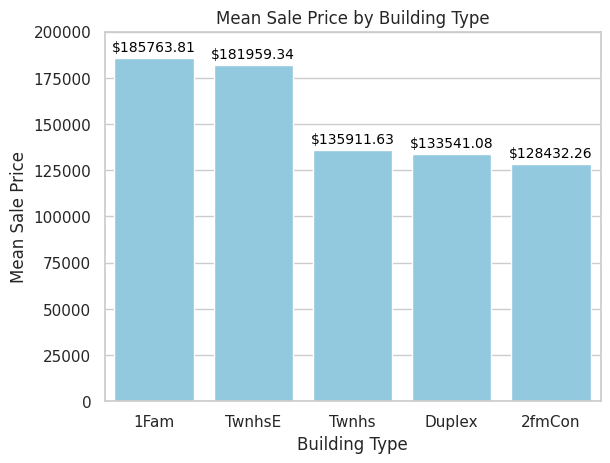

In [12]:
price_by_bldgtype = df.groupby('BldgType').SalePrice.mean().sort_values(ascending=False)
sns.barplot(x=price_by_bldgtype.index, y=price_by_bldgtype.values, color="skyblue")
plt.xlabel('Building Type')
plt.ylabel('Mean Sale Price')
plt.ylim(0, 200000)
plt.title('Mean Sale Price by Building Type')

# labelling generated with ChatGPT
for i, v in enumerate(price_by_bldgtype.values):
    plt.text(i, v + 2000, "$" + str(round(v, 2)), color='black', ha='center', va='bottom', fontsize=10)
    
plt.show()

In [13]:
df.SaleType.value_counts()

SaleType
WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: count, dtype: int64

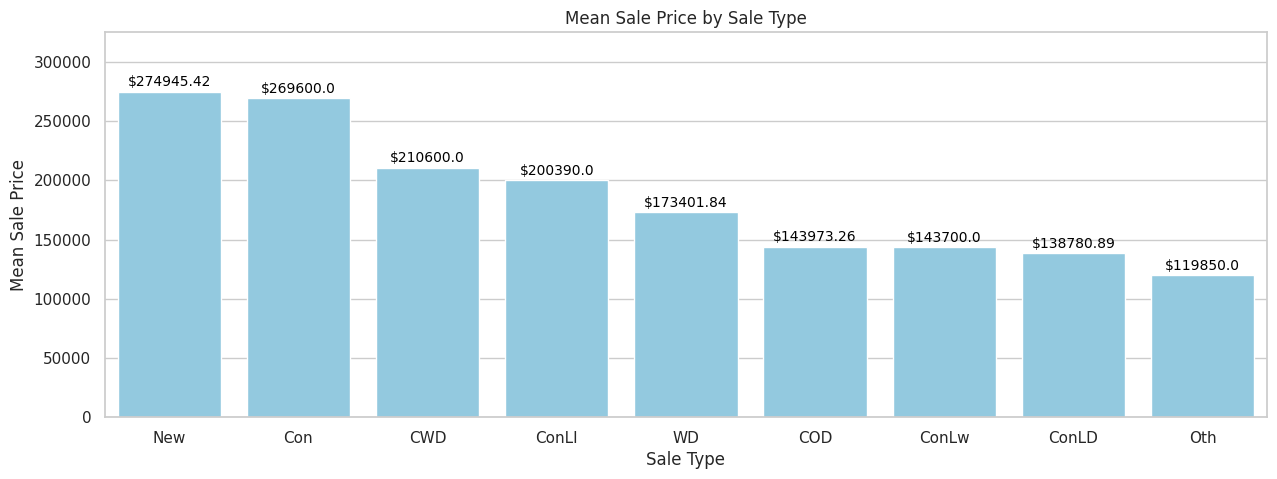

In [14]:
price_by_saletype = df.groupby('SaleType').SalePrice.mean().sort_values(ascending=False)
plt.figure(figsize=(15,5))
plt.ylim(0, 325000)

sns.barplot(x=price_by_saletype.index, y=price_by_saletype.values, color="skyblue")
plt.xlabel('Sale Type')
plt.ylabel('Mean Sale Price')

# labelling generated with ChatGPT
for i, v in enumerate(price_by_saletype.values):
    plt.text(i, v + 2000, "$" + str(round(v, 2)), color='black', ha='center', va='bottom', fontsize=10)
plt.title('Mean Sale Price by Sale Type')    
plt.show()

In [15]:
df.GarageType.value_counts()

GarageType
Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: count, dtype: int64

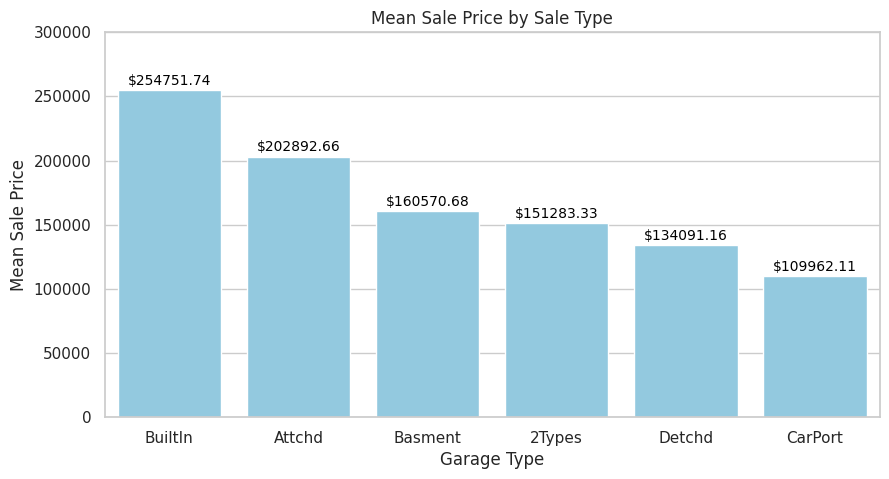

In [16]:
price_by_garagetype = df.groupby('GarageType').SalePrice.mean().sort_values(ascending=False)
plt.figure(figsize=(10,5))
plt.ylim(0, 300000)

sns.barplot(x=price_by_garagetype.index, y=price_by_garagetype.values, color="skyblue")
plt.xlabel('Garage Type')
plt.ylabel('Mean Sale Price')

# labelling generated with ChatGPT
for i, v in enumerate(price_by_garagetype.values):
    plt.text(i, v + 2000, "$" + str(round(v, 2)), color='black', ha='center', va='bottom', fontsize=10)
plt.title('Mean Sale Price by Sale Type')    
plt.show()

### numerical data


In [17]:
high_std_values = numerical_data.std().loc[numerical_data.std() > 50] 
# gut feeling at first was that it is probably better to just look at data with higher variance when examining scatterplots
high_std_values

LotArea          9981.264932
MasVnrArea        181.066207
BsmtFinSF1        456.098091
BsmtFinSF2        161.319273
BsmtUnfSF         441.866955
TotalBsmtSF       438.705324
1stFlrSF          386.587738
2ndFlrSF          436.528436
GrLivArea         525.480383
GarageArea        213.804841
WoodDeckSF        125.338794
OpenPorchSF        66.256028
EnclosedPorch      61.119149
ScreenPorch        55.757415
MiscVal           496.123024
dtype: float64

In [18]:
low_std_values = numerical_data.std().loc[numerical_data.std() <= 50] 
low_std_values
# still decided to investigate low std values too just to make sure we aren't losing important information

MSSubClass      42.300571
LotFrontage     24.284752
OverallQual      1.382997
OverallCond      1.112799
YearBuilt       30.202904
YearRemodAdd    20.645407
LowQualFinSF    48.623081
BsmtFullBath     0.518911
BsmtHalfBath     0.238753
FullBath         0.550916
HalfBath         0.502885
BedroomAbvGr     0.815778
KitchenAbvGr     0.220338
TotRmsAbvGrd     1.625393
Fireplaces       0.644666
GarageYrBlt     24.689725
GarageCars       0.747315
3SsnPorch       29.317331
PoolArea        40.177307
MoSold           2.703626
YrSold           1.328095
dtype: float64

In [19]:
# for feature in high_std_values.index:
#     temp_df = df[df[feature] != 0] # a lot of "0s" piling up which could indicate just a lack of something rather than relating to the continous variable
#     # temp_df = df # uncomment this to see the correlations with the 0s being considered as well
    
#     sns.regplot(x=temp_df[feature], y=temp_df.SalePrice)
    
#     # R^2 calculation done with GPT
#     corr_matrix = np.corrcoef(temp_df[feature], temp_df.SalePrice)
#     r_squared = corr_matrix[0, 1]**2
#     plt.text(0.95, 0.05, f'R^2 = {r_squared:.4f}', ha='right', va='bottom', transform=plt.gca().transAxes)
    
#     plt.title("Sale Price vs. " + feature)
#     plt.show()
# old visualization without grid format

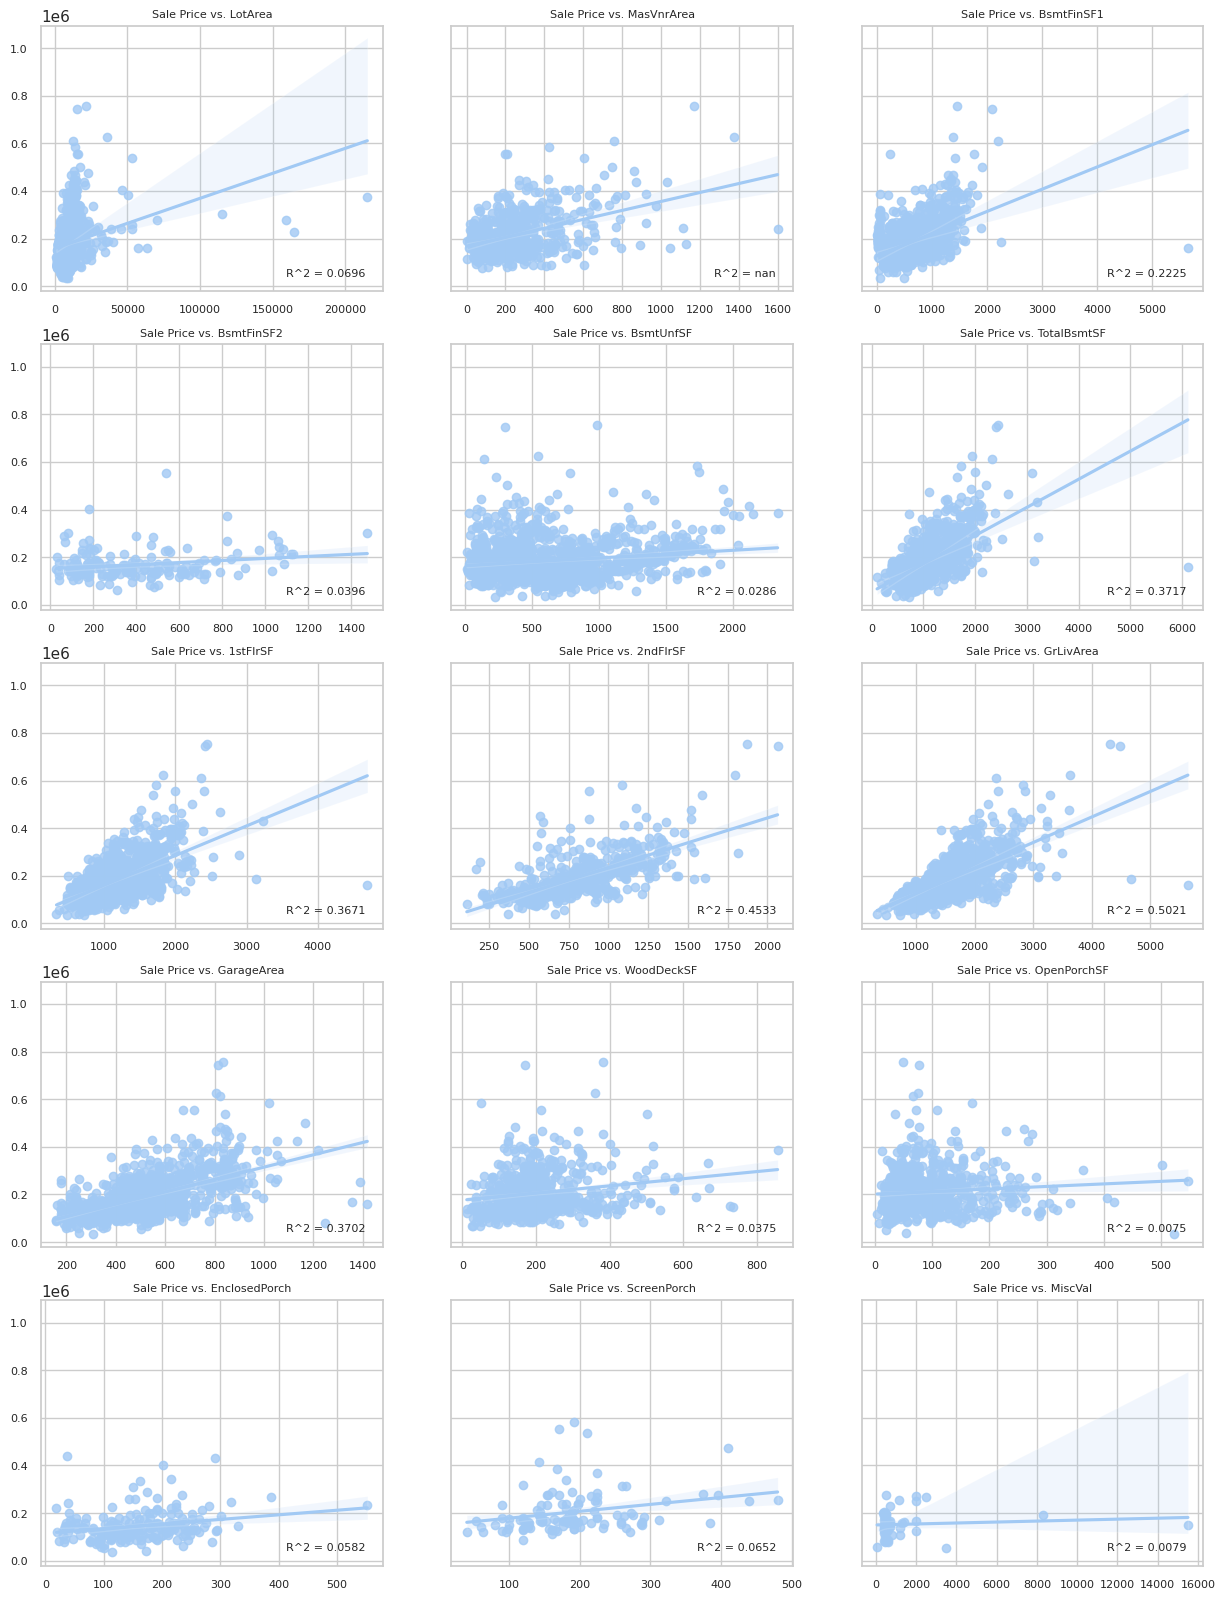

In [20]:
ncols = 3
nrows = (len(high_std_values)//ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 4*nrows), sharey=True) # to display grid-style
axes = axes.flatten()

for i, feature in enumerate(high_std_values.index):
    temp_df = df[df[feature] != 0] # a lot of "0s" piling up which could indicate just a lack of something rather than relating to the continous variable
    # temp_df = df # uncomment this to see the correlations with the 0s being considered as well
    
    sns.regplot(x=temp_df[feature], y=temp_df.SalePrice, ax=axes[i])
    
    # R^2 calculation done with GPT
    corr_matrix = np.corrcoef(temp_df[feature], temp_df.SalePrice)
    r_squared = corr_matrix[0, 1]**2
    axes[i].annotate(f'R^2 = {r_squared:.4f}', xy=(0.95, 0.05), xycoords='axes fraction', ha='right', va='bottom', fontsize=8)
    
    axes[i].tick_params(labelsize=8)
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].set_title("Sale Price vs. " + feature, fontsize=8)

plt.show()

#### observations
- noticing some linear relationships in like 2ndFlrSF, GarageArea
- GrLivArea, TotalBsmtSF, 1stFlrSF also have stronger regression lines BUT the residuals wouldn't be even so not a proper linear relationship
    - basically the size related ones of pretty "common sense" major areas of the house
- there seems to be an outlier with a very low sale price but high SF in a few graphs, not sure if its the same point or different ones though
- open porch and 1st floor SF just look like they are fanning out for now but could potentially mean interations with other values creating like one line with a steeper slope and another with a flatter one? just a thought to explore
    
**reminder to not forget that many of these hold a lot of 0 values worth reincoporating/investigating/dealing with separately later**

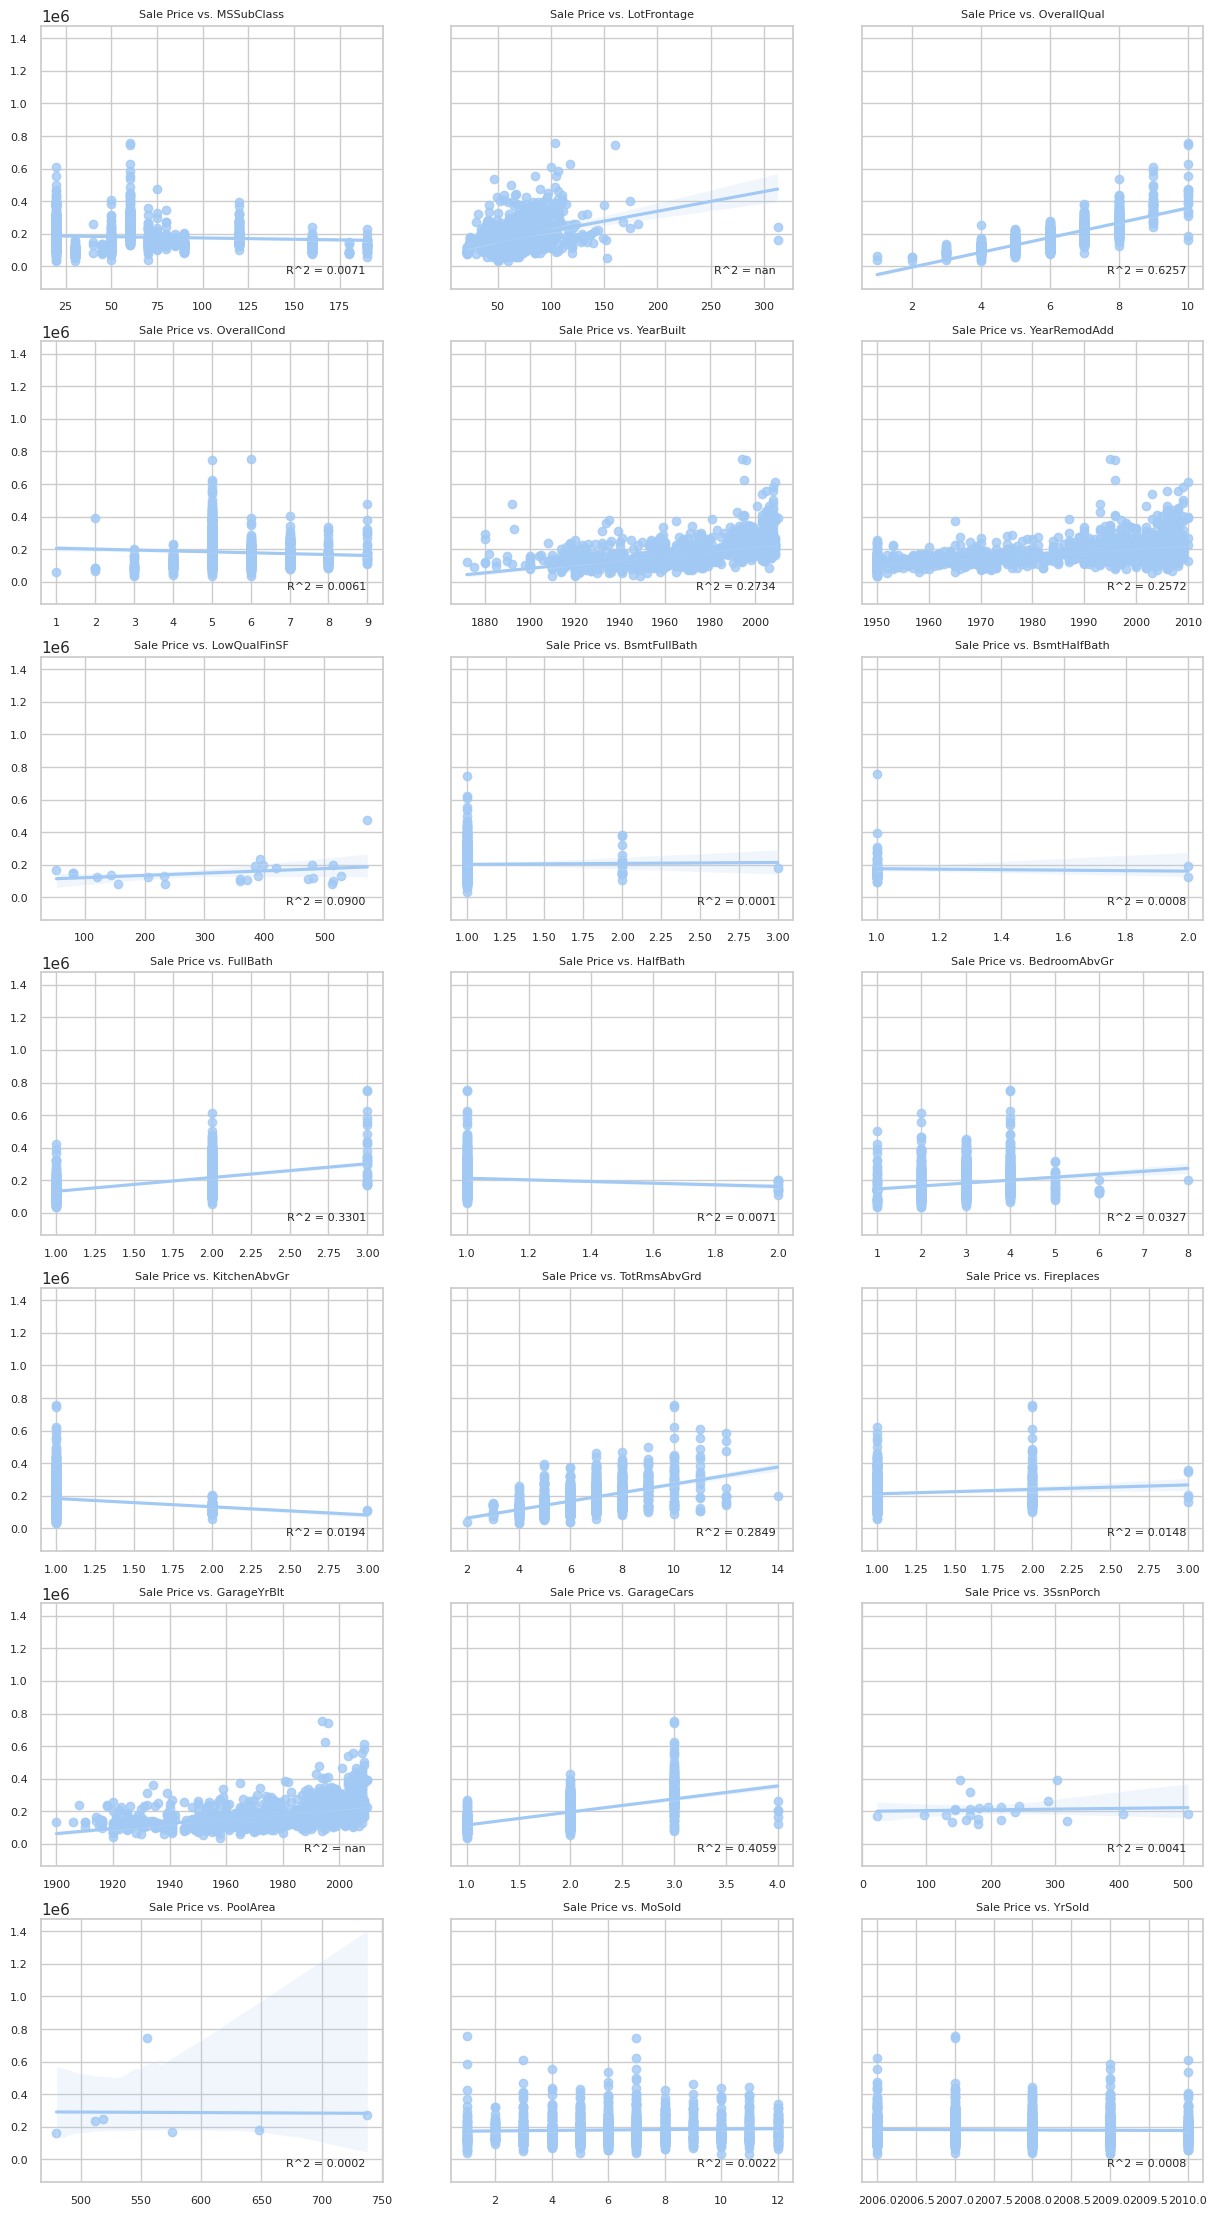

In [21]:
ncols = 3
nrows = (len(low_std_values)//ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 4*nrows), sharey=True) # to display grid-style
axes = axes.flatten()

for i, feature in enumerate(low_std_values.index):
    temp_df = df[df[feature] != 0] # a lot of "0s" piling up which could indicate just a lack of something rather than relating to the continous variable
    # temp_df = df # uncomment this to see the correlations with the 0s being considered as well
    
    sns.regplot(x=temp_df[feature], y=temp_df.SalePrice, ax=axes[i])
    
    # R^2 calculation done with GPT
    corr_matrix = np.corrcoef(temp_df[feature], temp_df.SalePrice)
    r_squared = corr_matrix[0, 1]**2
    axes[i].annotate(f'R^2 = {r_squared:.4f}', xy=(0.95, 0.05), xycoords='axes fraction', ha='right', va='bottom', fontsize=8)
    
    axes[i].tick_params(labelsize=8)
    axes[i].set_ylabel('') # just to save space
    axes[i].set_xlabel('')
    axes[i].set_title("Sale Price vs. " + feature, fontsize=8)

plt.show()

### observations
- MSSubClass, OverallCond, OverallQual are more-so ordinal categorical data hidden as numerical values
- many of the other low std values are simply discrete counts like number of bathrooms, rooms, kitchens etc.
- very few pool data points as we saw when checking nulls, could be better to remove/make binary again
- month and year are very un-promising for now, can't think of any reason why it would matter later yet either for now
- overall quality + total rooms above ground seem to have more of a correlation with price which also checks out logically
- random note: later when dealing with the model, check the normality of these quantative variables too

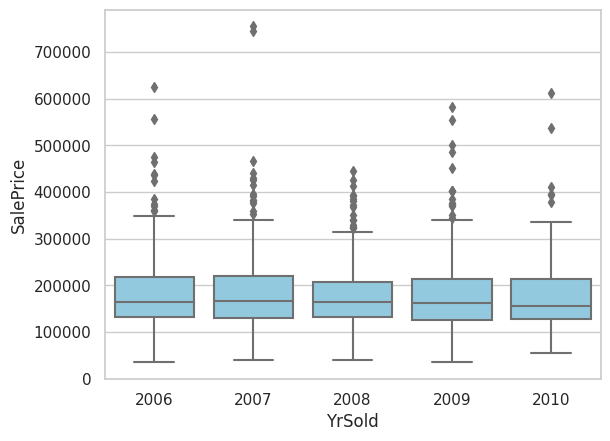

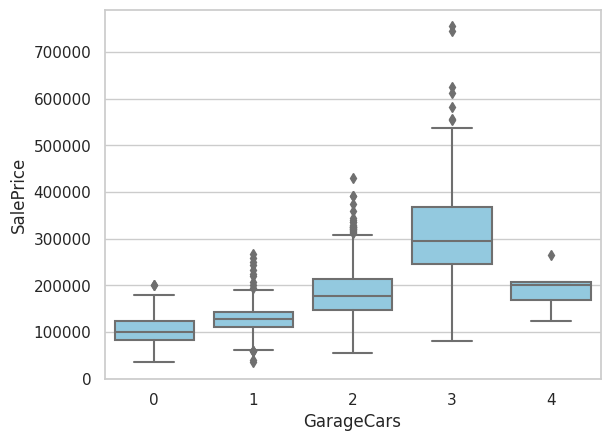

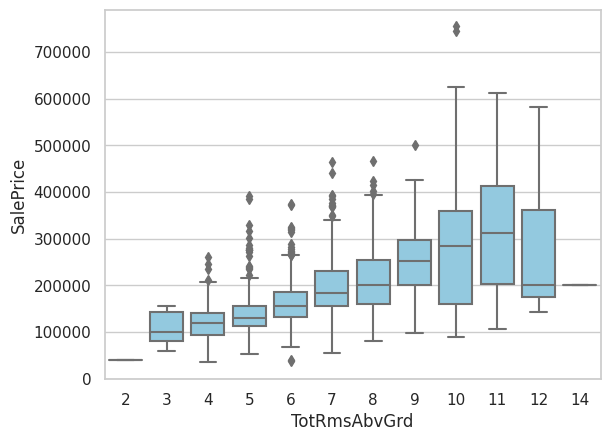

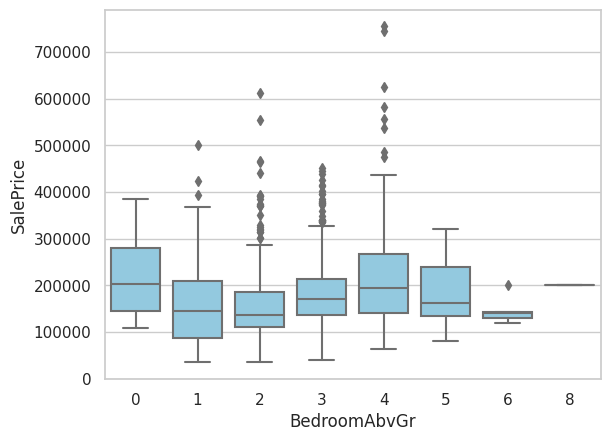

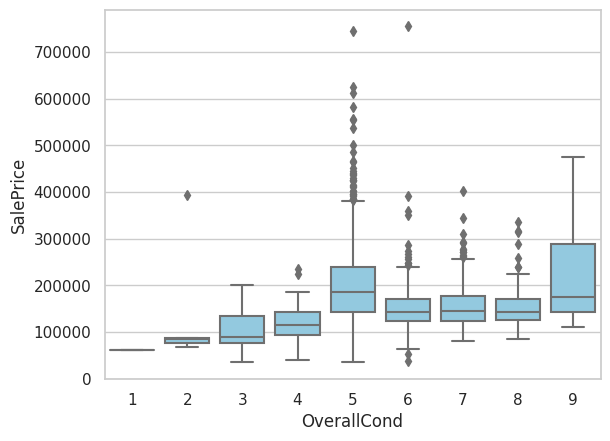

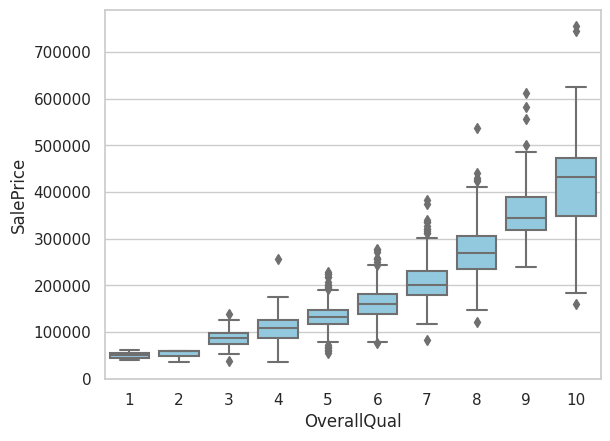

In [22]:
# just inspecting some more features to get a better sense of the data

inspecting_features = ['YrSold', 'GarageCars', 'TotRmsAbvGrd', 'BedroomAbvGr', 'OverallCond', 'OverallQual']
for feature in inspecting_features:
    sns.boxplot(x=df[feature], y=df.SalePrice, color="skyblue")
    plt.show() # nothing too crazy so far

# step 2/3: building a basic pipeline 
imputing, preprocessing, baseline to compare future models to make sure we're making meaningful changes

In [23]:
from sklearn.model_selection import train_test_split

# i don't think the data has any null Prices but for future reference
# it is good to remove rows with missing targets
df.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = df.SalePrice
X = df.drop('SalePrice', axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# separate numerical and categorical transformers
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
#     ('imputer', SimpleImputer(strategy='constant')), 
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('imputer', SimpleImputer(strategy='constant', fill_value="Missing")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    # can try target encoding too from Feature Engineering course
])

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

numerical_cols = numerical_data.columns
categorical_cols = categorical_data.columns

# combining transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# creating pipeline bundle for both preprocessing and modeling the code
def use_pipeline(model):
    return Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

# evaluating the model based on 3-fold cross validation
def get_score(model, X_train = X_train, y_train = y_train, X_valid = X_valid, y_valid = y_valid):
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, predictions))
    
    scores = -1 * cross_val_score(model, X_train, y_train,
                                  cv=3, scoring='neg_root_mean_squared_error')
    return rmse, scores.mean()

# step 4: comparing different models

In [26]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# testing different models and parameters, code generated with the help of ChatGPT
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=1),
    'XGBoost': XGBRegressor(random_state=1)
}

hyperparam_combos = {
    'LinearRegression': {},
    'RandomForest': {
        'model__n_estimators': [100, 200, 500],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
    },
    'XGBoost': {
        'model__n_estimators': [100, 200, 500],
        'model__learning_rate': [0.1, 0.05, 0.01],
        'model__max_depth': [3, 6, 10],
    }
}

In [27]:
# comparing different models
# note that it might've been better/more efficient to use RandomizedSearchCV
# will use again to compare after more feature engineering is done
def compare_models(models=models, searchCV=GridSearchCV):
    for model_name, model in models.items():
        print(f"Currently tuning: {model_name}...")
        my_pipeline = use_pipeline(model)
        grid_search = searchCV(my_pipeline, hyperparam_combos[model_name], cv=3, scoring='neg_root_mean_squared_error')
        grid_search.fit(X_train, y_train)

        best_params = grid_search.best_params_
        highest_score = -1 * grid_search.best_score_

        print(f"Best parameters for {model_name}: {best_params}")
        print(f"Best RMSE for {model_name}: {highest_score:.2f}\n")
    
# compare_models()

# Currently tuning: LinearRegression...
# Best parameters for LinearRegression: {}
# Best RMSE for LinearRegression: 29043.48

# Currently tuning: RandomForest...
# Best parameters for RandomForest: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 500}
# Best RMSE for RandomForest: 28935.17

# Currently tuning: XGBoost...
# Best parameters for XGBoost: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 500}
# Best RMSE for XGBoost: 27434.09

# results using cv = 5 below

# Currently tuning: LinearRegression...
# Best parameters for LinearRegression: {}
# Best RMSE for LinearRegression: 28354.45

# Currently tuning: RandomForest...
# Best parameters for RandomForest: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__max_depth': 20}
# Best RMSE for RandomForest: 28828.60

# Currently tuning: XGBoost...
# Best parameters for XGBoost: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 500}
# Best RMSE for XGBoost: 27730.80

# feature engineering

In [28]:
from sklearn.feature_selection import mutual_info_regression
X_fe_train = pd.DataFrame(numerical_transformer.fit_transform(X_train[numerical_cols]), columns = numerical_cols)
X_fe_train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,-0.868365,0.982524,0.103212,2.131506,-0.513041,1.188032,1.078914,1.913593,-0.901062,-0.291823,...,1.434743,-0.742575,0.874116,-0.364703,-0.115333,4.546911,-0.058085,-0.092588,0.256396,-0.613562
1,-0.868365,-0.463358,-0.372881,-0.794852,-0.513041,-0.292501,-1.097548,-0.568178,-1.011427,-0.291823,...,-0.791166,-0.742575,-0.700461,-0.364703,-0.115333,-0.269109,-0.058085,-0.092588,0.623394,0.884118
2,-0.631142,0.500563,0.258919,-0.794852,1.278384,-1.641431,1.030548,-0.568178,0.627953,-0.291823,...,-0.198864,-0.742575,-0.700461,0.332315,-0.115333,-0.269109,-0.058085,-0.092588,0.623394,0.884118
3,-0.868365,0.000000,0.250040,1.399917,-0.513041,1.023528,0.837085,0.244438,1.789085,-0.291823,...,1.831204,0.436137,0.159725,-0.364703,-0.115333,-0.269109,-0.058085,-0.092588,0.256396,0.135278
4,-0.868365,2.332013,0.291070,0.668327,-0.513041,0.990627,0.837085,0.255419,-1.011427,-0.291823,...,1.764331,2.935007,0.480472,-0.364703,-0.115333,-0.269109,-0.058085,-0.092588,-1.945593,-1.362401
5,-0.868365,-0.366966,-0.288765,0.668327,-0.513041,1.089329,0.982182,-0.568178,-0.068726,-0.291823,...,-0.351716,-0.742575,0.947013,-0.364703,-0.115333,-0.269109,-0.058085,-0.092588,1.357390,0.884118
6,-0.868365,0.693348,-0.180537,-0.063262,-0.513041,-0.193799,-0.952451,-0.013623,0.467004,-0.291823,...,-0.160651,-0.742575,1.311499,-0.364703,-0.115333,-0.269109,-0.058085,-0.092588,2.091387,-1.362401
7,2.452769,-2.198415,-0.749343,0.668327,-0.513041,0.924826,0.691987,-0.568178,0.377332,-0.291823,...,0.049521,-0.742575,-0.058967,-0.364703,-0.115333,-0.269109,-0.058085,-0.092588,-0.477600,1.632958
8,2.927217,-2.343004,-0.840562,-1.526442,-0.513041,0.069407,-0.565524,-0.568178,0.050836,-0.291823,...,-0.843709,0.200395,0.772060,-0.364703,-0.115333,-0.269109,-0.058085,-0.092588,1.724388,0.884118
9,-0.156694,-0.463358,-0.428958,-0.063262,0.382672,-0.983416,-1.677938,-0.568178,-0.149201,-0.291823,...,-0.160651,-0.742575,-0.700461,-0.364703,-0.115333,-0.269109,-0.058085,-0.092588,-1.211597,-0.613562


In [29]:
mutual_info = mutual_info_regression(X_fe_train, y_train)
mutual_info

array([0.25863168, 0.2305806 , 0.17349252, 0.55939303, 0.10871196,
       0.35131421, 0.2251463 , 0.09653057, 0.17392495, 0.00263778,
       0.12186789, 0.39195208, 0.32860735, 0.21335606, 0.01594953,
       0.48513592, 0.02818504, 0.0050878 , 0.26013025, 0.07933752,
       0.05208251, 0.02137242, 0.19556675, 0.18002385, 0.29169226,
       0.38633529, 0.39167738, 0.09179755, 0.15049999, 0.01523752,
       0.        , 0.02455865, 0.        , 0.        , 0.        ,
       0.        ])

In [30]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_fe_train.columns
mutual_info = mutual_info.sort_values(ascending=False)

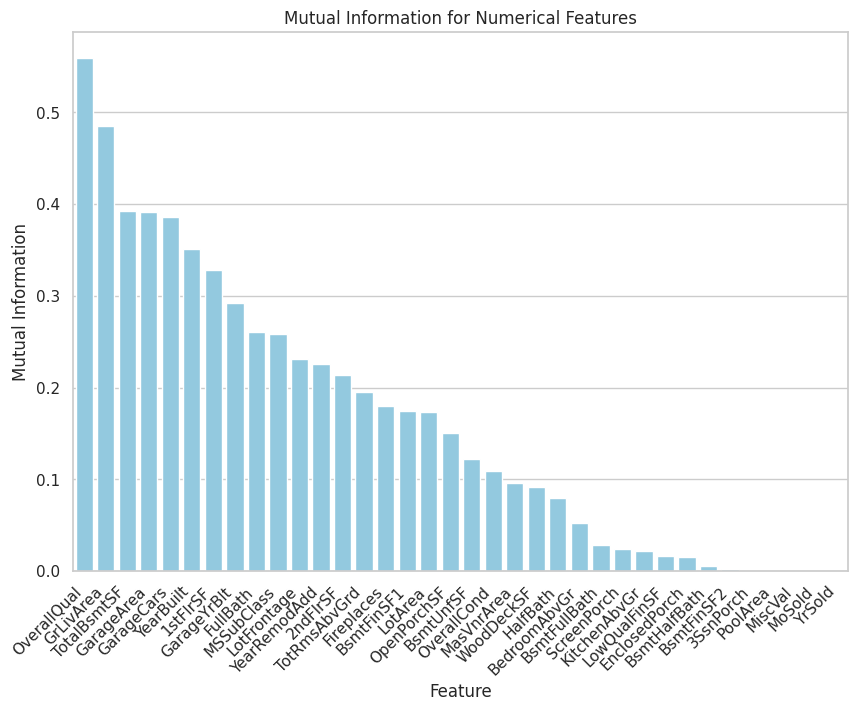

In [31]:
plt.figure(figsize = (10, 7))
sns.barplot(x=mutual_info.index, y=mutual_info, color = "skyblue")
plt.title('Mutual Information for Numerical Features')
plt.ylabel('Mutual Information')
plt.xlabel('Feature')
plt.xticks(rotation=45, ha = "right") 
plt.show()

### dropping low MI features leads to ___ results

In [32]:
low_mi_cols = ["MoSold", "MiscVal", "PoolArea", "LowQualFinSF", "BsmtHalfBath", "BsmtFinSF2", "YrSold", "KitchenAbvGr", "3SsnPorch"]
X_fe_train_copy = X_fe_train.copy()
X_dropped_train = X_fe_train_copy.drop(low_mi_cols, axis=1)
X_dropped_train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,...,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch
0,-0.868365,0.982524,0.103212,2.131506,-0.513041,1.188032,1.078914,1.913593,-0.901062,2.757198,...,0.146285,1.512184,0.605438,1.190532,1.683633,1.434743,-0.742575,0.874116,-0.364703,4.546911
1,-0.868365,-0.463358,-0.372881,-0.794852,-0.513041,-0.292501,-1.097548,-0.568178,-1.011427,0.745229,...,-1.100873,-0.951178,-0.955603,-0.665842,-1.057111,-0.791166,-0.742575,-0.700461,-0.364703,-0.269109
2,-0.631142,0.500563,0.258919,-0.794852,1.278384,-1.641431,1.030548,-0.568178,0.627953,-0.926076,...,-1.100873,-0.951178,-0.955603,-2.357205,0.313261,-0.198864,-0.742575,-0.700461,0.332315,-0.269109
3,-0.868365,0.000000,0.250040,1.399917,-0.513041,1.023528,0.837085,0.244438,1.789085,-0.498533,...,0.146285,0.280503,2.166479,0.984269,1.683633,1.831204,0.436137,0.159725,-0.364703,-0.269109
4,-0.868365,2.332013,0.291070,0.668327,-0.513041,0.990627,0.837085,0.255419,-1.011427,2.224484,...,0.146285,-0.335338,0.605438,0.943016,1.683633,1.764331,2.935007,0.480472,-0.364703,-0.269109
5,-0.868365,-0.366966,-0.288765,0.668327,-0.513041,1.089329,0.982182,-0.568178,-0.068726,0.555464,...,-1.100873,-0.335338,-0.955603,1.066774,0.313261,-0.351716,-0.742575,0.947013,-0.364703,-0.269109
6,-0.868365,0.693348,-0.180537,-0.063262,-0.513041,-0.193799,-0.952451,-0.013623,0.467004,-0.281332,...,0.146285,-0.335338,0.605438,-0.542084,0.313261,-0.160651,-0.742575,1.311499,-0.364703,-0.269109
7,2.452769,-2.198415,-0.749343,0.668327,-0.513041,0.924826,0.691987,-0.568178,0.377332,-1.088406,...,0.146285,-0.335338,-0.955603,0.860510,0.313261,0.049521,-0.742575,-0.058967,-0.364703,-0.269109
8,2.927217,-2.343004,-0.840562,-1.526442,-0.513041,0.069407,-0.565524,-0.568178,0.050836,-1.298748,...,-1.100873,-0.951178,-0.955603,-0.212061,-1.057111,-0.843709,0.200395,0.772060,-0.364703,-0.269109
9,-0.156694,-0.463358,-0.428958,-0.063262,0.382672,-0.983416,-1.677938,-0.568178,-0.149201,-0.475670,...,0.146285,-0.335338,0.605438,1.025521,0.313261,-0.160651,-0.742575,-0.700461,-0.364703,-0.269109


In [33]:
higher_fe_cols = [item for item in numerical_cols if item not in low_mi_cols]

X_dropped_train = pd.DataFrame(numerical_transformer.fit_transform(X_train[higher_fe_cols]), columns = higher_fe_cols)
X_fe_valid = pd.DataFrame(numerical_transformer.transform(X_valid[higher_fe_cols]), columns = higher_fe_cols)

higher_fe_cols

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'ScreenPorch']

In [34]:
# pre_fe_best = use_pipeline(XGBRegressor(n_estimators = 500, max_depth = 3, learning_rate = 0.1)) # from before
# pre_fe_best.fit(X_dropped_train)

In [35]:
# predictions = pre_fe_best.predict(X_fe_valid)
# rmse = np.sqrt(mean_squared_error(y_valid, predictions))
# scores = -1 * cross_val_score(model, X_dropped_train, y_train, cv=3, scoring='neg_root_mean_squared_error')
# print(rmse)

# submissions

In [36]:
X_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv', index_col='Id')

#### simple RandomForestRegressor 

In [37]:
# model_basic = 0.14526
# model_basic = use_pipeline(RandomForestRegressor(n_estimators=100, random_state=0))
model_basic = use_pipeline(RandomForestRegressor())
# rmse, cv_score = get_score(model_basic)
# print(f"RMSE: {rmse:.2f}") # 33370.59
# print(f"Average RMSE score: {cv_score:.2f}") # 28826.79

#### best model before feature engineering

In [38]:
# xgboost = 0.13536
pre_fe_best = use_pipeline(XGBRegressor(n_estimators = 500, max_depth = 3, learning_rate = 0.1))
# rmse, avg_score = get_score(pre_fe_best)
# print(rmse, avg_score) # 28967.581536128346

In [39]:
model_on_all_data = model_basic
model_on_all_data.fit(X, y)
predictions = model_on_all_data.predict(X_test)

output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': predictions})
output.to_csv('submission.csv', index=False)